In [123]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


[Learn the Basics](intro.html) ||
[Quickstart](quickstart_tutorial.html) ||
[Tensors](tensorqs_tutorial.html) ||
[Datasets & DataLoaders](data_tutorial.html) ||
[Transforms](transforms_tutorial.html) ||
[Build Model](buildmodel_tutorial.html) ||
[Autograd](autogradqs_tutorial.html) ||
**Optimization** ||
[Save & Load Model](saveloadrun_tutorial.html)

# Optimizing Model Parameters

Now that we have a model and data it's time to train, validate and test our model by optimizing its parameters on
our data. Training a model is an iterative process; in each iteration the model makes a guess about the output, calculates
the error in its guess (*loss*), collects the derivatives of the error with respect to its parameters (as we saw in
the [previous section](autograd_tutorial.html)), and **optimizes** these parameters using gradient descent. For a more
detailed walkthrough of this process, check out this video on [backpropagation from 3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8)_.

## Prerequisite Code
We load the code from the previous sections on [Datasets & DataLoaders](data_tutorial.html)
and [Build Model](buildmodel_tutorial.html).


In [124]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.models import *

torch.manual_seed(0)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cuda"
print(f"Using {device} device")

# training_data = datasets.FashionMNIST(
#     root="data",
#     train=True,
#     download=True,
#     transform=ToTensor()
# )


# test_data = datasets.FashionMNIST(
#     root="data",
#     train=False,
#     download=True,
#     transform=ToTensor()
# )

# k = 10

transform_training = v2.Compose([
    v2.ToImage(),
    # lambda img: v2.functional.rotate(img, -90),
    # lambda img: v2.functional.hflip(img),
    # v2.RandomAffine(degrees=15, translate=(.05, .05), scale=(.5, 1.1), shear=(-10, 10, -10, 10)),
    # v2.GaussianBlur(5, .5),
    v2.ToDtype(torch.float32, scale=True),
])

transform_test = v2.Compose([
    v2.ToImage(),
    # lambda img: v2.functional.rotate(img, -90),
    # lambda img: v2.functional.hflip(img),
    v2.ToDtype(torch.float32, scale=True)
])

training_data = datasets.EMNIST(
    root="data",
    split="balanced",
    train=True,
    download=True,
    transform=transform_training
)

# training_data = torch.utils.data.Subset(training_data, range(512))


test_data = datasets.EMNIST(
    root="data",
    split="balanced",
    train=False,
    download=True,
    transform=transform_test
)

k = 47

workers = 0
batch_size = 256

train_dataloader = DataLoader(training_data, shuffle=True, batch_size=batch_size, num_workers=workers)
test_dataloader = DataLoader(test_data, shuffle=True, batch_size=batch_size, num_workers=workers)



model = get_model("efficientnet_v2_s", num_classes=k, dropout=.2)
model.features[0][0] = nn.Conv2d(1, 24, 3, 2, 1, bias=False) # s is 24, l is 32
model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params:,}")
# print(model)

Using cuda device
Number of parameters: 20,237,263


In [125]:
emnist = {}

with open("./data/EMNIST/emnist_balanced_mapping.txt") as f:
    f = f.read()
    for line in f.split("\n"):
        line = line.split()
        emnist[int(line[0])] = int(line[1])    

def emnist_to_char(label):
    return chr(emnist[label])

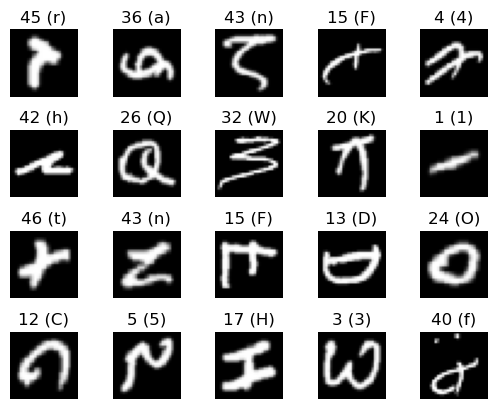

In [126]:
import matplotlib.pyplot as plt
import math

# Function to plot multiple images
def plot_images(images, emnist_to_char, num_images=10):
    # plt.figure(figsize=(15, 15))

    iterator = iter(images)
    for i in range(num_images):
        image, label = next(iterator)
        plt.subplot(math.ceil(num_images / 5), 5, i + 1)
        plt.imshow(image.squeeze(), cmap="gray")
        plt.title(f'{label} ({emnist_to_char(label)})')
        plt.axis('off')
    plt.subplots_adjust(hspace=.5)
    plt.show()

# Call the function to plot images
plot_images(training_data, emnist_to_char, num_images=20)

In [127]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

In [129]:

transform = v2.RandomAffine(degrees=15, translate=(.05, .05), scale=(.5, 1.1), shear=(-10, 10, -10, 10))

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        X = transform(X)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]", end = "\t")


def test_loop(dataloader, model, loss_fn, transform=lambda x: x):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            X = transform(X)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"\nTest Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct * 100

In [130]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 3e-4
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [138]:
epochs = 1000
no_improve_epochs = 0
quit = -1
best = 0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    res = test_loop(test_dataloader, model, loss_fn)
    if res < best + .1:
        no_improve_epochs += 1
    else:
        no_improve_epochs = 0
    if no_improve_epochs == -1:
        break
    best = max(best, res)

print("Done!")

Epoch 1
-------------------------------
loss: 0.048024  [  256/112800]	loss: 0.027585  [25856/112800]	loss: 0.007233  [51456/112800]	loss: 0.039364  [77056/112800]	loss: 0.030831  [102656/112800]	
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.879055 

Epoch 2
-------------------------------
loss: 0.004916  [  256/112800]	loss: 0.003070  [25856/112800]	loss: 0.028399  [51456/112800]	loss: 0.019419  [77056/112800]	loss: 0.010496  [102656/112800]	
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.824049 

Epoch 3
-------------------------------
loss: 0.024763  [  256/112800]	loss: 0.005438  [25856/112800]	loss: 0.013372  [51456/112800]	loss: 0.027542  [77056/112800]	loss: 0.005905  [102656/112800]	
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.904141 

Epoch 4
-------------------------------
loss: 0.027256  [  256/112800]	loss: 0.011442  [25856/112800]	loss: 0.057844  [51456/112800]	loss: 0.008672  [77056/112800]	loss: 0.000568  [102656/112800]	
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.836924 

Epoc

KeyboardInterrupt: 

In [132]:
cp = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict()
}

torch.save(cp, "./models/new")

In [133]:
test_loop(test_dataloader, model, loss_fn, transform)


Test Error: 
 Accuracy: 76.7%, Avg loss: 1.299481 



76.73404255319149

In [134]:
# model.load_state_dict(torch.load("models/88")["model"])
# test_loop(test_dataloader, model, loss_fn, transform)

## Further Reading
- [Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)
- [torch.optim](https://pytorch.org/docs/stable/optim.html)
- [Warmstart Training a Model](https://pytorch.org/tutorials/recipes/recipes/warmstarting_model_using_parameters_from_a_different_model.html)


